In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from bruit_schiolerSilverman import schioler
from bruit_schiolerSilverman import jeuDeDonnees_schioler_bruite
from bruit_schiolerSilverman import jeuDeDonnees_schioler_bruite_inhomogene
from bruit_schiolerSilverman import affichage_illustratif_schioler

from bruit_schiolerSilverman import silverman
from bruit_schiolerSilverman import jeuDeDonnees_silverman_bruite
from bruit_schiolerSilverman import affichage_illustratif_silverman

from bruit_schiolerSilverman import decoupageEnDeuxSousEnsembles
from bruit_schiolerSilverman import affichage_ensembles

# Données simulées (pour la régression des PMC)
***

Le but de ce TP est de mettre en oeuvre une méthodologie constructive pour déterminer une fonction de régression à l’aide de perceptrons multicouches (PMC). 
Ce TP comporte 2 Parties :
- Un PMC réalisant une régression à partir de données brutes simulées pour approximer l’espérance.
- Une approximation de la variance de données brutes également effectuée par une régression à l’aide d’un PMC.

Ce TP permettra de faire ressortir quelques notions associées à l'apprentissage de la régression. 
Nous nous limitons ici à l'apprentissage de données simulées dans deux cas simples.
Nous considérons, ici, des fonctions (connues et de complexité limitée) caractérisées par une entrée et une sortie qui seront apprises sur un intervalle réduit.
**L'objectif est d'appréhender les notions associées à l'apprentissage pour être ensuite apte à traiter des problèmes plus réalistes.** Cela va bien au-delà d'apprendre les deux fonction étudiées ou d'afficher de bonnes performances d'apprentissage (pour ces deux fonctions). 


Dans cette partie nous présentons les jeux de données simulées. 
Pour chaque jeu de données nous aurons une fonction à une entrée et une sortie qui représentera la fonction théorique à retrouver. On ajoutera un bruit à cette fonction pour générer notre jeu de données. On pourra ainsi, a volo, génerer des jeux de données simulées constituées d'une entrée et de la sortie (bruitée) correspondante.

### Fonction "Schioler" et "Silverman"

Dans cette partie, on présente les deux fonctions que l'on cherchera à estimer à partir des PMC.

On rappelle qu'un PMC fournit en sortie une réponse moyenne (moyennée sur le bruit) connaissant la valeur qui lui est fournie en entrée. On a ainsi :

$$\hat{f}(x) = E[Y|X=x]
\qquad\text{avec $\hat{f}(x)$ la fonction  estimée à l'aide du PMC.}$$

Dans de bonnes conditions, et en particulier avec un bruit de moyenne nulle (ce qui n'est pas toujours le cas), on devrait, à l'aide du PMC, retrouver quelque chose de très proche de la fonction $f$.

Dans le cadre de ce TP, pour bien comprendre ce qui est appris par les PMC, il est donc important de s'intéresser aux fonctions que l'on va apprendre.

Dans la suite, on va travailler avec deux types de bruit. 

Le premier sera gaussien, additif et stationnaire. Il sera donc caractérisé par une espérance et une variance indépendante des valeurs prises en entrée $x$ et en sortie $y$ de la fonction.

Le second sera un mélange d'un bruit uniforme de paramètres constants et d'un bruit gaussien dont la variance dépendra de $x$. On aura donc un bruit qui dépendra de la valeur en entrée. Dans la seconde partie on s'intéressera à l'apprentissage de ce paramètre. 

## Principe de la simulation des jeux de données

On a une fonction $f$ dont on ne connait que quelques valeurs bruitées prises aléatoirement sur un intervalle donné.

On considère un intervalle $[x_\text{min} ; x_\text{max}]$ sur lequel $N$ valeurs $x_i$ sont tirées aléatoirement.  
Pour chacun des $x_i$, on mesure une valeur $y_i$ somme d'un bruit et la valeur prise par la fonction en $x_i$.  
On a ainsi : $\displaystyle y_i = f(x_i) + \varepsilon_i $

Pour générer notre jeu de données, on va donc devoir tirer des valeurs aléatoires de x (que l'on ordonnera dans la suite).  

Dans ce qui suit on s'intéressera à deux types de fonctions $f$ : 
 - schioler : 
$ f = 
\displaystyle
\left\{
\begin{array}{ll} 
sin(\pi x) & \text{sur } ]-1,1[ \\
     0     & \text{sur } ]-2,-1[ \cup ]1,2[ 
\end{array}
\right.
$ 
  
 - silverman : 
$ f = \displaystyle
 \left\{
 \begin{array}{ll}
 sin(2\pi (1-x)^2) & \text{sur } ]0,1[               \\
      0            & \text{sur } ]-0.25,0[ \cup ]1,2[ \\
 \end{array}
 \right.
$
 

On s'intéressera aussi à deux types de bruit $\varepsilon$ :

 - schioler :  $\varepsilon \sim \mathcal{N}(0,\sigma)$


 - silverman : 
$
\text{ et }
 \varepsilon \sim \mathcal{N}(0,\sigma_x)
\text{ avec } 
 \sigma_x^2 = 
 \left\{ 
 \begin{array}{ll}
 0.05^2 & \text{si } x \leq 0.05 \\
    x^2 & \text{si } x > 0.05    \\
 \end{array}
 \right.
$

$\varepsilon$ sera stationnaire pour les jeux de données "schioler" et non stationnaire pour le jeu de données "silverman".  
(Dans ce cas le bruit dépendra de $x$, $\varepsilon(x)$.)

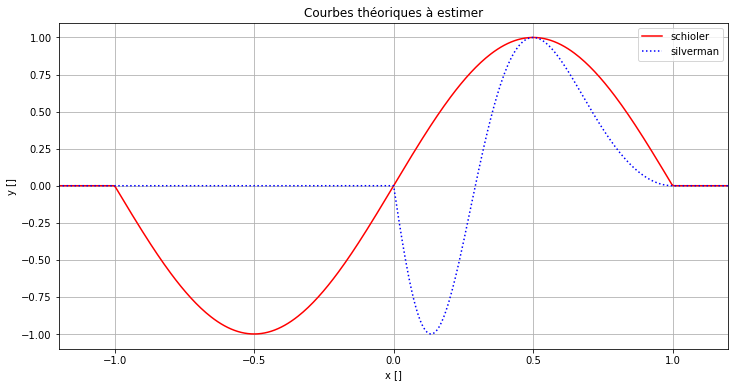

In [3]:
#### Affichage des courbes
n_maillage = 1000
# Abscisse régulière pour l'affichage des courbes
x_maillage = np.linspace(-2,4,n_maillage).reshape(n_maillage,1)
plt.figure(figsize=(12,6))
plt.plot(x_maillage,schioler(x_maillage),'r-',label='schioler')
plt.plot(x_maillage,silverman(x_maillage),'b:',label='silverman')
plt.axis([-1.2, 1.2, -1.1, 1.1])
plt.xlabel('x []')
plt.ylabel('y []')
plt.grid(True)
plt.legend()
plt.title("Courbes théoriques à estimer") ;

## Jeux de données "Schioler"

### La nature du bruit et l'allure de la fonction 
Dans les cas associée à la fonction "schioler", le bruit est stationnaire autrement dit, il ne dépend pas de la valeur de $x$.

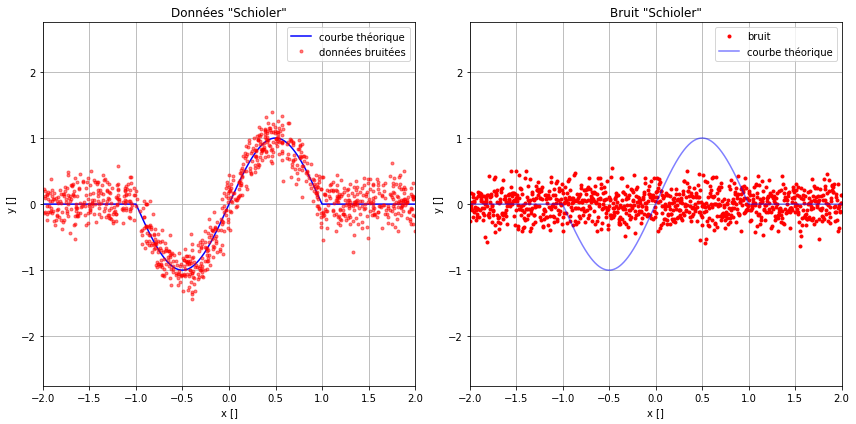

In [4]:
plt.figure(figsize=(12,6))
affichage_illustratif_schioler()
plt.tight_layout()

On va considérer trois cas de figure.  
Le premier jeu de données correspond à des données réparties uniformément en $x$.  
Les deux autres avec des $x$ répartis uniformément mais sur des sous-intervalles. 
On ne couvrira donc qu'une partie des entrées possibles sur l'intervalle d'apprentissage. 

### Le premier jeu de données "schioler" : intervalle complet \[-2, 2\]

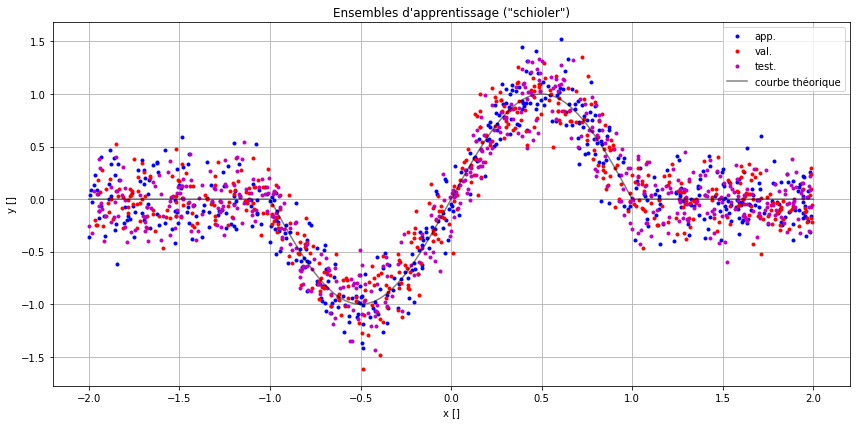

In [5]:
# generation des jeux de données simulées
# ensembles d'apprentissage et de validation
nombreDeDonnees_appVal = 1000
nombreDeDonnees_test = 500
xi,yi = jeuDeDonnees_schioler_bruite(nombreDeDonnees_appVal,sigma=.2)
r_l=.5 # proportion de l'ensemble d'apprentissage 
x_app, y_app, x_val, y_val = decoupageEnDeuxSousEnsembles(xi,yi,r_l)

# ensemble de test (performances en generalisation une fois l'apprentissage termine)
x_test,y_test = jeuDeDonnees_schioler_bruite(nombreDeDonnees_test,sigma=.2)
n_test = np.size(x_test,0)

# Abscisse régulière pour l'affichage des courbes
n_maillage = 1000
x_maillage = np.linspace(-2,2,n_maillage).reshape(n_maillage,1) 

# generation des ensembles d'apprentissage et de validation (performances en generalisation)
r_l=.5 # proportion de l'ensemble d'apprentissage 
x_app, y_app, x_val, y_val  = decoupageEnDeuxSousEnsembles(xi,yi,r_l,)
n_app = np.size(x_app,0)
n_val = np.size(x_val,0)

plt.figure(figsize=(12,6))
affichage_ensembles(x_app, y_app, x_val, y_val, x_test, y_test,fonction=schioler)
plt.title('''Ensembles d'apprentissage ("schioler")''')
plt.tight_layout()

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

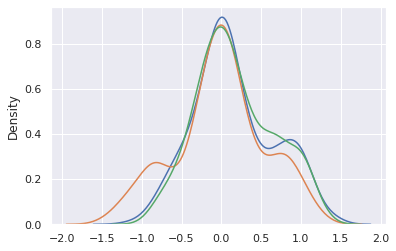

In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns

sns.distplot(y_app, hist=False )
sns.distplot(y_test, hist=False )
sns.distplot(y_val, hist=False)

plt.show()


### Le second jeu de données "schioler" : premier sous-intervalle \[-2, -0.75\] U\[-0.25, 1\] U \[1.25, 2\]

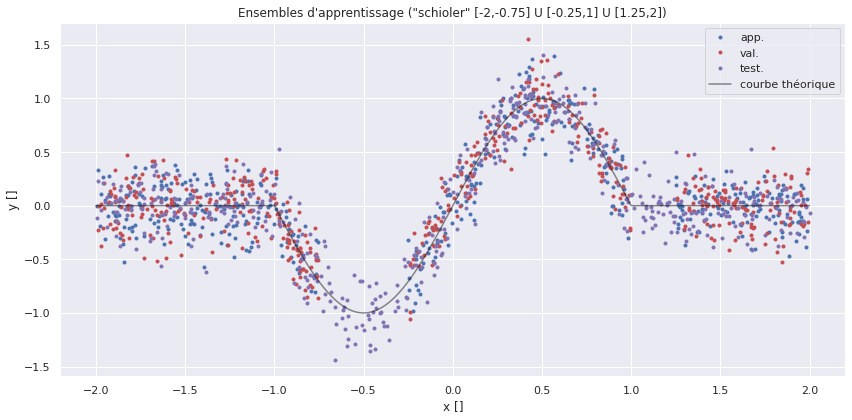

In [49]:
# generation des jeux de données simulées
# ensembles d'apprentissage et de validation
nombreDeDonnees_appVal = 1000
nombreDeDonnees_test = 500
a1=-2; b1=-.75 ; a2=-.25 ; b2=1 ; a3=1.25 ; b3=2
xi,yi = jeuDeDonnees_schioler_bruite_inhomogene(nombreDeDonnees_appVal,a1=a1,b1=b1,a2=a2,b2=b2,a3=a3,b3=b3,sigma=.2)
r_l=.5 # proportion de l'ensemble d'apprentissage 
x_app, y_app, x_val, y_val = decoupageEnDeuxSousEnsembles(xi,yi,r_l)

# ensemble de test (performances en generalisation une fois l'apprentissage termine)
x_test,y_test = jeuDeDonnees_schioler_bruite(nombreDeDonnees_test,sigma=.2)
n_test = np.size(x_test,0)

# Abscisse régulière pour l'affichage des courbes
n_maillage = 1000
x_maillage = np.linspace(-2,2,n_maillage).reshape(n_maillage,1) 

# generation des ensembles d'apprentissage et de validation (performances en generalisation)
r_l=.5 # proportion de l'ensemble d'apprentissage 
x_app, y_app, x_val, y_val  = decoupageEnDeuxSousEnsembles(xi,yi,r_l,)
n_app = np.size(x_app,0)
n_val = np.size(x_val,0)

plt.figure(figsize=(12,6))
affichage_ensembles(x_app, y_app, x_val, y_val, x_test, y_test,fonction=schioler)
if a3 == None and b3 == None:
    titre = '''Ensembles d'apprentissage ("schioler" [{},{}] U [{},{}])'''.format(a1,b1,a2,b2)
else:
    titre = '''Ensembles d'apprentissage ("schioler" [{},{}] U [{},{}] U [{},{}])'''.format(a1,b1,a2,b2,a3,b3)
plt.title(titre)
plt.tight_layout()

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level funct

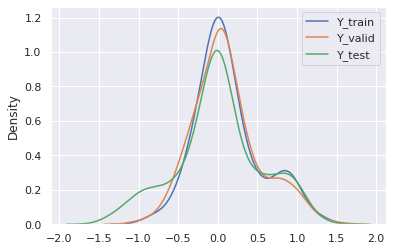

In [50]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns

sns.distplot(y_app, hist=False ,label="Y_train")
sns.distplot(y_val, hist=False,label="Y_valid" )
sns.distplot(y_test, hist=False,label="Y_test")
plt.legend()

plt.show()


### Le troisième jeu de données "schioler" : premier sous-intervalle \[-2, -0.75\] U \[-0.25, 1\]

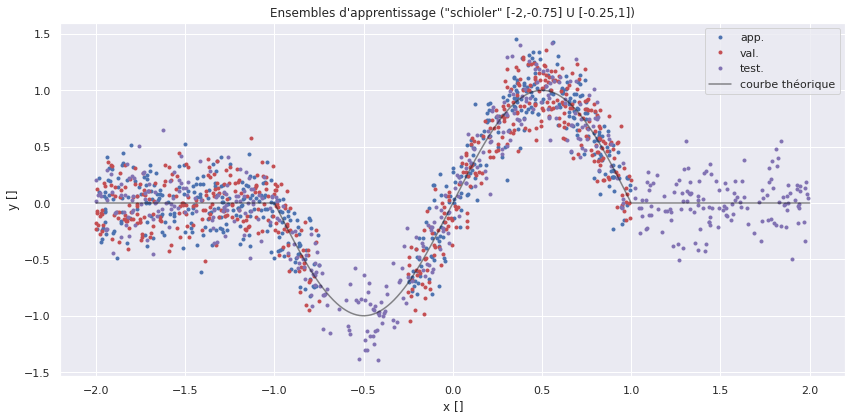

In [55]:
# generation des jeux de données simulées
# ensembles d'apprentissage et de validation
nombreDeDonnees_appVal = 1000
nombreDeDonnees_test = 500
a1=-2 ; b1=-.75 ; a2=-.25 ; b2=1; a3=None; b3=None

xi,yi = jeuDeDonnees_schioler_bruite_inhomogene(nombreDeDonnees_appVal,a1=a1,b1=b1,a2=a2,b2=b2,sigma=.2)
r_l=.5 # proportion de l'ensemble d'apprentissage 
x_app, y_app, x_val, y_val = decoupageEnDeuxSousEnsembles(xi,yi,r_l)

# ensemble de test (performances en generalisation une fois l'apprentissage termine)
x_test,y_test = jeuDeDonnees_schioler_bruite(nombreDeDonnees_test,sigma=.2)
n_test = np.size(x_test,0)

# Abscisse régulière pour l'affichage des courbes
n_maillage = 1000
x_maillage = np.linspace(-2,2,n_maillage).reshape(n_maillage,1) 

# generation des ensembles d'apprentissage et de validation (performances en generalisation)
r_l=.5 # proportion de l'ensemble d'apprentissage 
x_app, y_app, x_val, y_val  = decoupageEnDeuxSousEnsembles(xi,yi,r_l,)
n_app = np.size(x_app,0)
n_val = np.size(x_val,0)

plt.figure(figsize=(12,6))
affichage_ensembles(x_app, y_app, x_val, y_val, x_test, y_test,fonction=schioler)
if a3 == None and b3 == None:
    titre = '''Ensembles d'apprentissage ("schioler" [{},{}] U [{},{}])'''.format(a1,b1,a2,b2)
else:
    titre = '''Ensembles d'apprentissage ("schioler" [{},{}] U [{},{}] U [{},{}])'''.format(a1,b1,a2,b2,a3,b3)
plt.title(titre)
plt.tight_layout()

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level funct

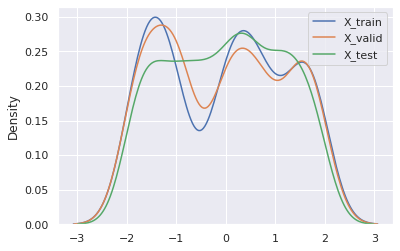

In [54]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns

sns.distplot(x_app, hist=False ,label="X_train")
sns.distplot(x_val, hist=False,label="X_valid" )
sns.distplot(x_test, hist=False,label="X_test")
plt.legend()

plt.show()


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level funct

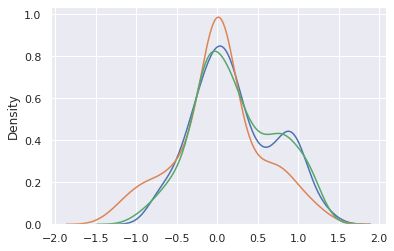

In [56]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns

sns.distplot(y_app, hist=False )
sns.distplot(y_test, hist=False )
sns.distplot(y_val, hist=False)

plt.show()


## Jeu de données "Silverman"

### La nature du bruit et l'allure de la fonction 

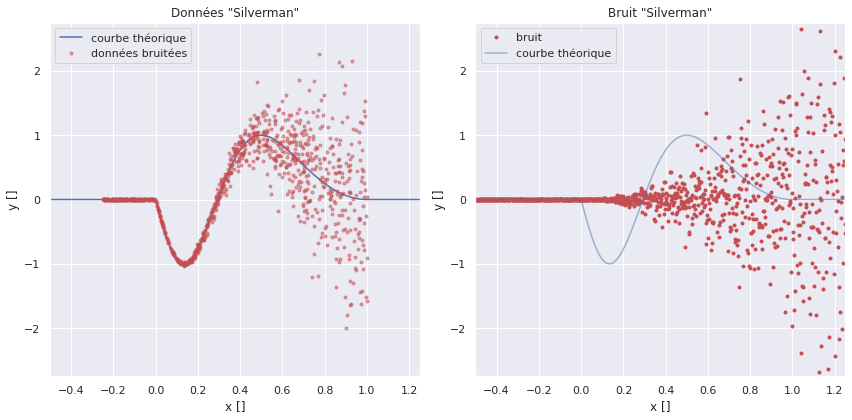

In [57]:
plt.figure(figsize=(12,6))
affichage_illustratif_silverman()
plt.tight_layout()

On constate la dépendance du bruit en $x$. On a donc bien un bruit non stationnaire.

### Le jeu de données de l'apprentissage

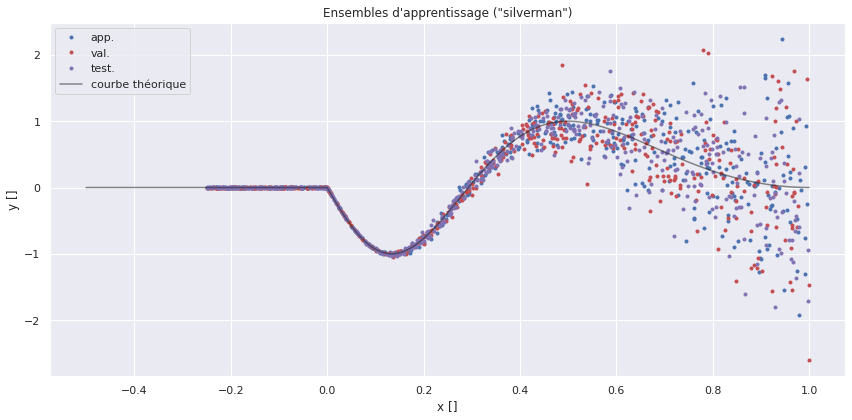

In [58]:
# generation des jeux de données simulées
# ensembles d'apprentissage et de validation
nombreDeDonnees_appVal = 1000
nombreDeDonnees_test = 500
xi,yi = jeuDeDonnees_silverman_bruite(nombreDeDonnees_appVal,sigma=1)
r_l=.5 # proportions des differents ensembles de l'apprentissage 
x_app, y_app, x_val, y_val = decoupageEnDeuxSousEnsembles(xi,yi,r_l)

# ensemble de test (performances en generalisation une fois l'apprentissage termine)
x_test,y_test = jeuDeDonnees_silverman_bruite(nombreDeDonnees_test,sigma=1)

# Abscisse régulière pour l'affichage des courbes
n_maillage = 1000
x_maillage = np.linspace(-.5,1.25,n_maillage).reshape(n_maillage,1) 

plt.figure(figsize=(12,6))
affichage_ensembles(x_app, y_app, x_val, y_val, x_test, y_test,fonction=silverman)
plt.title('''Ensembles d'apprentissage ("silverman")''')
plt.tight_layout()

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level funct

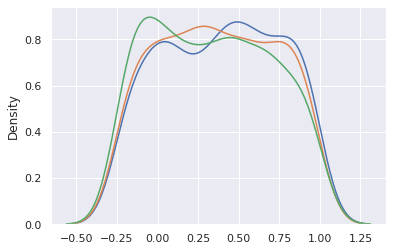

In [60]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns

sns.distplot(x_app, hist=False )
sns.distplot(x_test, hist=False )
sns.distplot(x_val, hist=False)

plt.show()


In [62]:
dd=pd.DataFrame(x_app)
dd.pairplot()

AttributeError: 'DataFrame' object has no attribute 'pairplot'